[View in Colaboratory](https://colab.research.google.com/github/juzkev/MBTI-Type/blob/master/MBTI.ipynb)

# Predicting Myer-Briggs Type Indicators from forum posts
	• Goal 1: To classify people's MBTI personality based on their forum post text
	• Goal 2: To test the model on another open text dataset such as IMDB reviews or Twitter messages, Reddit messages, requires good vocab overlap.
	• Goal 3: To re-encode text as a specific personality style.

In [1]:
# Google Colab specific setup for Kaggle API
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])

os.makedirs(os.path.dirname(filename), exist_ok=True)
fh = io.FileIO(filename, 'wb')

downloader = MediaIoBaseDownload(fh, request)

done = False

while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
    
os.chmod(filename, 600)

!pip install kaggle
!kaggle datasets download -d datasnaek/mbti-type -f mbti_1.csv -p /content
!unzip -o mbti_1.csv.zip -d /input

Download 100%.
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
mbti_1.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  mbti_1.csv.zip
  inflating: /input/mbti_1.csv       


In [0]:
import numpy as np
import pandas as pd
import datetime

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv('/input/mbti_1.csv')

In [34]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
type     8675 non-null object
posts    8675 non-null object
dtypes: object(2)
memory usage: 135.6+ KB


,type,posts
count,8675,8675
unique,16,8675
top,INFP,'I really like the way you put that. It makes ...
freq,1832,1


In [23]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [69]:
[p.split('|||')[:5] for p in df.head(2).posts]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.'],
 ["'I'm finding the lack of me in these posts very alarming.",
  "Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...",
  "Giving new meaning to 'Game' theory.",
  "Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.",
  'This + Lack of Balance and Ha

In [25]:
# Consider spliting personality type along E-I, S-N, T-F, J-P axis
df2 = (df.assign(EI = lambda df: df.type.str.extract('([EI])', expand=False))
         .assign(SN = lambda df: df.type.str.extract('([SN])', expand=False))
         .assign(TF = lambda df: df.type.str.extract('([TF])', expand=False))
         .assign(JP = lambda df: df.type.str.extract('([JP])', expand=False))
      )
df2.head()
# For use in modelling in later stages

,type,posts,EI,SN,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


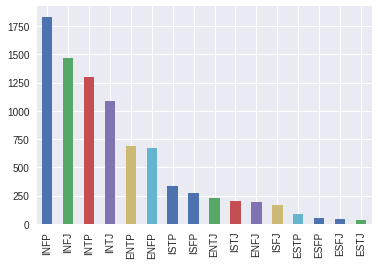

In [67]:
df2.type.value_counts().plot(kind="bar")

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install -q torchtext

import torchtext

In [21]:
!pip install spacy
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 17.6MB 2.0MB/s 
    100% |████████████████████████████████| 92kB 19.1MB/s 
    100% |████████████████████████████████| 1.2MB 16.0MB/s 
    100% |████████████████████████████████| 51kB 17.7MB/s 
    100% |████████████████████████████████| 194kB 20.0MB/s 
    100% |████████████████████████████████| 71kB 17.4MB/s 
    100% |████████████████████████████████| 604kB 16.0MB/s 
    100% |████████████████████████████████| 389kB 21.4MB/s 
    100% |████████████████████████████████| 143kB 21.1MB/s 
    100% |████████████████████████████████| 51kB 16.2MB/s 
  Running setup.py bdist_wheel for spacy ... - \ |

 / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / -^C
 error
  Failed building wheel for spacy
  Running setup.py clean for spacy
/usr/bin/python3: No module named spacy


In [22]:
import re
import spacy 
spacy_en = spacy.load('en')
def tokenizer(text): # create a tokenizer function
    text = re.sub(r'\|\|\|', '\n', text) # replace '|||' post spliters with line break
    # To remove stopwords of personality types themselves
    return [tok.text for tok in spacy_en.tokenizer(text)]

TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer, lower=True)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

ModuleNotFoundError: ignored

In [58]:
starttime = datetime.datetime.now()
train, val, test = torchtext.data.TabularDataset(
        path='/input/mbti_1.csv', format='csv',
        fields=[('type', LABEL), ('posts', TEXT)]).split([.6, .2, .2])
print(datetime.datetime.now()-starttime)

0:04:46.753087


In [0]:
TEXT.build_vocab(train, vectors="glove.6B.100d")

In [78]:
a = train.examples[0]
a.posts[:20]

["'",
 'wow',
 ',',
 'you',
 'guys',
 'are',
 'awesome',
 '.',
 ' ',
 'that',
 "'s",
 'a',
 'great',
 'starting',
 'point',
 'for',
 'me',
 '.',
 ' ',
 'thanks']

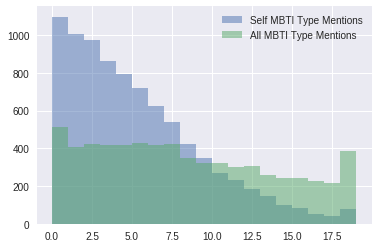

In [66]:
# There are many mentions of their own personalities in thier own posts
df2['self_type_mentions'] = df2.apply(lambda x: x.posts.count(x.type), axis=1)
df2['MBTI_type_mentions'] = df2.posts.str.count('[EI][SN][TF][JP]')

bins = range(0, 20)

plt.hist(df2['self_type_mentions'], bins, alpha=0.5, label='Self MBTI Type Mentions')
plt.hist(df2['MBTI_type_mentions'], bins, alpha=0.5, label='All MBTI Type Mentions')
plt.legend(loc='upper right')
plt.show()

In [38]:
# E-I, S-N, T-F, J-P
import itertools
a = [['E', 'I'],['S', 'N'],['T', 'F'],['J', 'P']]
MBTI_types = (pd.DataFrame(list(itertools.product(*a)), 
                           columns=['EI','SN','TF','JP'])
                .assign(type = lambda x: x.EI + x.SN + x.TF + x.JP)
                .type)
MBTI_types


0     ESTJ
1     ESTP
2     ESFJ
3     ESFP
4     ENTJ
5     ENTP
6     ENFJ
7     ENFP
8     ISTJ
9     ISTP
10    ISFJ
11    ISFP
12    INTJ
13    INTP
14    INFJ
15    INFP
Name: type, dtype: object

0     578
1    1194
2     869
3    1101
4     987
Name: posts, dtype: int64


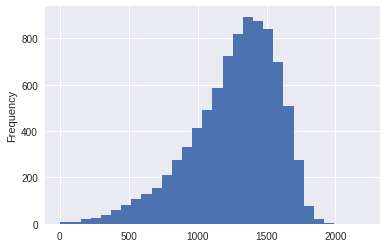

50    7587
47      82
48      79
42      61
49      60
Name: posts, dtype: int64


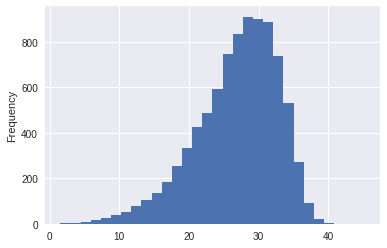

In [136]:
# Calculate number of posts, number of words per post

# Number of words
print(df2.posts.apply(lambda x: len(x.split(' ')))
               .head())

df2.posts.apply(lambda x: len(x.split(' '))).plot.hist(bins=30)
plt.show()

# Number of Posts
print(df2.posts.apply(lambda x: len(x.split('|||')))
               .value_counts()
               .sort_values(ascending = False)
               .head())

# Average words per post
def countAvgWdPerPost(posts):
  return np.mean([len(post.split(' ')) 
                 for post 
                 in posts.split('|||')
                ])
  
df2.posts.apply(countAvgWdPerPost).plot.hist(bins=30)